# Results Checker for Predictions

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

directory = 'C:/Users/99451/Desktop/MODEL/2025/dixon_coles_model_predictions/_predictions.xlsx'
predictions = pd.read_excel(directory)
predictions['League'] = predictions['League'].str.capitalize()

predictions.tail()

,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U
1132,Usa,DC United,Charlotte,30.34,28.54,41.12,1-1,58.88,71.46,69.66,77.74,51.99,70.18,85.45,57.19,33.31,35.64,30.88,0-0,68.95,64.19,66.52,76.95,59.31,71.62,77.60,35.87,44.09,86.63,80.98
1133,Usa,Inter Miami,New England,81.05,12.28,6.09,3-0,93.33,87.14,18.37,91.43,76.66,41.94,61.46,56.13,54.65,27.81,16.58,1-0,82.46,71.23,44.39,83.38,47.51,95.35,57.86,82.32,21.61,37.98,93.63
1134,Usa,New York RB,Columbus Crew,27.94,26.28,45.77,1-1,54.22,73.71,72.05,82.69,59.46,62.91,80.15,62.25,25.38,46.04,28.55,0-0,71.42,53.93,74.59,62.45,75.86,73.65,82.56,38.51,52.11,84.92,74.48
1135,Usa,Orlando City,Atlanta Utd,50.42,26.55,23.01,1-1,76.97,73.43,49.56,79.70,54.93,67.41,83.50,57.41,37.13,44.77,18.05,0-0,81.90,55.18,62.82,63.16,75.05,82.63,67.66,52.22,31.16,74.38,89.44
1136,Usa,Philadelphia,Cincinnati,44.81,24.37,30.80,1-1,69.18,75.61,55.17,87.77,68.16,53.35,72.27,69.17,45.19,34.89,19.65,0-0,80.08,64.84,54.54,76.06,60.16,85.45,79.49,57.43,47.02,69.58,78.70


# Finding Game Results

In [2]:
final =  pd.DataFrame()
liqa = ''
unique_leagues = predictions['League'].unique().tolist()

for i in unique_leagues:
    URL = "https://www.soccerstats.com/results.asp?league=" + i + "&pmtype=bydate"
    page = requests.get(URL)
    liqa = i
    soup = BeautifulSoup(page.content, "html.parser")
    results = soup.find(id="btable")
    sth = results.find_all("tr", class_="odd")
    sth


    date, league, home, away, ft, ht = [], [], [], [], [],[]
    for i in sth:
        date.append(i.find_all("td", align = 'right')[0].get_text(strip=True))
        league.append(liqa.capitalize())
        home.append(i.find_all("td", align = 'right')[1].get_text(strip=True))
        away.append(i.find("td", align = "left").get_text(strip = True))
        ft.append(i.find_all("td", align = 'center')[0].get_text(strip = True))
        try:
            ht.append(i.find_all("td", align = 'center')[2].get_text(strip = True))
        except IndexError as e:
            ht.append('NA')#print("Last output before error occurred:", i.find_all("td", align = 'center'))

    data = {'Date': date, 'League': league,'Home': home, 'Away': away, 'FT': ft, 'HT': ht}

# Create a DataFrame from the dictionary
    df = pd.DataFrame(data)

# Replace empty strings with NaN
    #next_df = df[(df['Date'] == formatted_date) & (df['HT'] == '')]
    df.replace('', pd.NA, inplace=True)

# Drop rows with NaN values
    df_cleaned = df.dropna()

#For Half-Time Results
    hthg, htag = [], []
    for i in df_cleaned['HT']:
        if i == 'NA':
            hthg.append('NA')
            htag.append('NA')
        elif i == '+' or i == '-':
            hthg.append('NA')
            htag.append('NA')
        else:
            try:
                hthg.append(int(i[1]))
                htag.append(int(i[3]))
            except IndexError as e:
                print("Last output before error occurred:", i)



#For Full-Time Results
    hg, ag, tg = [], [], []
    for i in df_cleaned['FT']:
        if len(i) < 5 or ':' in i:
            hg.append('NA')
            ag.append('NA')
            tg.append('NA')
        else:
            try:
                hghg = int(i.split(' - ')[0])
                hg.append(hghg)
                agag = int(i.split(' - ')[1])
                ag.append(agag)
                tg.append(hghg + agag)
            except:
                print(hghg + agag)

    
    df_cleaned['FTHG'], df_cleaned['FTAG'], df_cleaned['FTTG'] = hg, ag, tg
    df_cleaned['HTHG'], df_cleaned['HTAG'] = hthg, htag
    df_cleaned['HTTG'] = df_cleaned['HTHG'] + df_cleaned['HTAG']
    
    final = pd.concat([final, df_cleaned], ignore_index=True)
    
final = final[final['HT'] != 'NA']

# Example: Fix the 'date' column by removing the weekday and extra punctuation
final['Date'] = final['Date'].str.extract(r'(\d{1,2} \w{3})')  # Extract day and month part
final['Date'] = final['Date'] + ' 2024'  # Append the year

# Convert to datetime format
final['Date'] = pd.to_datetime(final['Date'], format='%d %b %Y', errors='coerce')

# Filter rows before September 6th, 2024
final_filtered = final[final['Date'] >= pd.Timestamp('2024-09-06')]
combined = pd.concat([final_filtered.head(), final_filtered.tail()])

combined

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
39,2024-09-13,Spain,Real Betis,Leganes,2 - 0,(0-0),2,0,2,0,0,0
40,2024-09-14,Spain,Mallorca,Villarreal,1 - 2,(0-1),1,2,3,0,1,1
41,2024-09-14,Spain,Espanyol,Alaves,3 - 2,(1-1),3,2,5,1,1,2
42,2024-09-14,Spain,Sevilla FC,Getafe,1 - 0,(1-0),1,0,1,1,0,1
43,2024-09-14,Spain,Real Sociedad,Real Madrid,0 - 2,(0-0),0,2,2,0,0,0
4921,2024-10-12,Portugal2,Tondela,Leixoes,2 - 1,(0-1),2,1,3,0,1,1
4922,2024-10-12,Portugal2,Alverca,Penafiel,2 - 2,(1-1),2,2,4,1,1,2
4923,2024-10-13,Portugal2,Academico Viseu,Maritimo,0 - 2,(0-0),0,2,2,0,0,0
4924,2024-10-13,Portugal2,Pacos Ferreira,Torreense,1 - 0,(0-0),1,0,1,0,0,0
4925,2024-10-13,Portugal2,Chaves,Feirense,0 - 0,(0-0),0,0,0,0,0,0


# Choosing the matches that are on the xlsx and taking their results

In [ ]:
# Combine df and final based on 'League', 'Home', and 'Away'
combined_df = pd.merge(predictions, final_filtered, on=['League', 'Home', 'Away'], how='left')
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df = combined_df.dropna(subset=['Date'])
combined_df = combined_df.drop_duplicates(subset=['Home', 'Away'])
combined_df = combined_df.reset_index(drop=True) #Regularize index of combined_df
combined_df.tail()

,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
1071,Scotland,St. Johnstone,Ross County,41.21,28.78,30.00,1-1,69.99,71.21,58.78,85.86,62.30,59.93,77.81,66.38,5.11,47.09,47.62,0-0,52.20,52.73,94.71,61.77,68.78,82.42,77.12,51.87,43.38,74.69,81.50,2024-10-19,3 - 0,(2-0),3.0,0.0,3.0,2.0,0.0,2.0
1072,Spain,Athletic Bilbao,Espanyol,72.95,24.35,2.65,2-0,97.30,75.60,27.00,80.11,51.74,70.36,85.57,39.59,64.80,29.73,4.36,1-0,94.53,69.16,34.09,75.82,54.89,89.33,39.62,65.52,9.16,61.13,98.47,2024-10-19,4 - 1,(3-0),4.0,1.0,5.0,3.0,0.0,3.0
1073,Spain,Osasuna,Real Betis,47.50,38.63,13.86,1-1,86.13,61.36,52.49,77.59,45.03,76.25,89.42,53.44,28.38,54.74,16.86,0-0,83.12,45.24,71.60,53.16,80.60,79.77,58.48,47.44,21.99,78.39,94.05,2024-10-19,1 - 2,(0-1),1.0,2.0,3.0,0.0,1.0,1.0
1074,Spain,Girona,Real Sociedad,52.29,38.52,9.18,0-0,90.81,61.47,47.70,70.59,37.27,82.26,92.93,43.90,39.37,53.02,7.57,0-0,92.39,46.94,60.59,52.00,82.09,78.44,47.73,45.36,13.82,80.02,97.18,2024-10-19,0 - 1,(0-1),0.0,1.0,1.0,0.0,1.0,1.0
1075,Turkey,Kayserispor,Gaziantep,21.29,40.09,38.62,1-1,61.38,59.91,78.71,73.28,40.62,79.76,91.53,52.07,23.51,57.06,19.42,0-0,80.57,42.93,76.48,52.19,79.49,62.37,73.57,25.59,38.41,92.38,84.99,2024-10-19,2 - 2,(1-2),2.0,2.0,4.0,1.0,2.0,3.0


# Checking Predictions To See if Correct or Not

In [4]:
ftrs = []
ftscs = []
dcs = []
overs15 = []
overs25 = []
unders35 = []
unders45 = []
bttss = []
htrs = []
htdcs = []
htscs = []
htovers05 = []
htunders15 = []
homeovers05 = []
awayovers05 = []
homeovers15 = []
awayovers15 = []
homeunders25 = []
awayunders25 = []

for i in range(len(combined_df)):
    full_time_results = [combined_df['FT1'].iloc[i], combined_df['FTX'].iloc[i], combined_df['FT2'].iloc[i]]
    if full_time_results.index(max(full_time_results)) == 0 and combined_df['FTHG'].iloc[i] > combined_df['FTAG'].iloc[i]:
        ftrs.append(1)
    elif full_time_results.index(max(full_time_results)) == 1 and combined_df['FTHG'].iloc[i] == combined_df['FTAG'].iloc[i]:
        ftrs.append(1)
    elif full_time_results.index(max(full_time_results)) == 2 and combined_df['FTHG'].iloc[i] < combined_df['FTAG'].iloc[i]:
        ftrs.append(1)
    else:
        ftrs.append(0)
    
    if combined_df['FTR'].iloc[i] == combined_df['FT'].iloc[i].replace(' ', ''):
        ftscs.append(1)
    else:
        ftscs.append(0)

    double_chances = [combined_df['DC1X'].iloc[i], combined_df['DC12'].iloc[i], combined_df['DCX2'].iloc[i]]
    if double_chances.index(max(double_chances)) == 0 and combined_df['FTHG'].iloc[i] >= combined_df['FTAG'].iloc[i]:
        dcs.append(1)
    elif double_chances.index(max(double_chances)) == 2 and combined_df['FTHG'].iloc[i] <= combined_df['FTAG'].iloc[i]:
        dcs.append(1)
    elif double_chances.index(max(double_chances)) == 1 and combined_df['FTHG'].iloc[i] != combined_df['FTAG'].iloc[i]:
        dcs.append(1)
    else:
        dcs.append(0)
    
    if combined_df['1.5O'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] > 1.5:
        overs15.append(1)
    elif combined_df['1.5O'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] < 1.5:
        overs15.append(1)
    else:
        overs15.append(0)
    
    if combined_df['2.5O'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] > 2.5:
        overs25.append(1)
    elif combined_df['2.5O'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] < 2.5:
        overs25.append(1)
    else:
        overs25.append(0)
    
    if combined_df['3.5U'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] < 3.5:
        unders35.append(1)
    elif combined_df['3.5U'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] > 3.5:
        unders35.append(1)
    else:
        unders35.append(0)
    
    if combined_df['4.5U'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] < 4.5:
        unders45.append(1)
    elif combined_df['4.5U'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] > 4.5:
        unders45.append(1)
    else:
        unders45.append(0)

    if combined_df['BTTS'].iloc[i] > 50 and (combined_df['FTHG'].iloc[i] != 0 and combined_df['FTAG'].iloc[i] != 0):
        bttss.append(1)
    elif combined_df['BTTS'].iloc[i] < 50 and (combined_df['FTHG'].iloc[i] == 0 or combined_df['FTAG'].iloc[i] == 0):
        bttss.append(1)
    else:
        bttss.append(0)
    
    half_time_results = [combined_df['HT1'].iloc[i], combined_df['HTX'].iloc[i], combined_df['HT2'].iloc[i]]
    if half_time_results.index(max(half_time_results)) == 0 and combined_df['HTHG'].iloc[i] > combined_df['HTAG'].iloc[i]:
        htrs.append(1)
    elif half_time_results.index(max(half_time_results)) == 1 and combined_df['HTHG'].iloc[i] == combined_df['HTAG'].iloc[i]:
        htrs.append(1)
    elif half_time_results.index(max(half_time_results)) == 2 and combined_df['HTHG'].iloc[i] < combined_df['HTAG'].iloc[i]:
        htrs.append(1)
    else:
        htrs.append(0)
    
    if combined_df['HTR'].iloc[i] == combined_df['HT'].iloc[i].replace('(', '').replace(')', ''):
        htscs.append(1)
    else:
        htscs.append(0)
    
    ht_double_chances = [combined_df['HTDC1X'].iloc[i], combined_df['HTDC12'].iloc[i], combined_df['HTDCX2'].iloc[i]]
    if ht_double_chances.index(max(ht_double_chances)) == 0 and combined_df['HTHG'].iloc[i] >= combined_df['HTAG'].iloc[i]:
        htdcs.append(1)
    elif ht_double_chances.index(max(ht_double_chances)) == 2 and combined_df['HTHG'].iloc[i] <= combined_df['HTAG'].iloc[i]:
        htdcs.append(1)
    elif ht_double_chances.index(max(ht_double_chances)) == 1 and combined_df['HTHG'].iloc[i] != combined_df['HTAG'].iloc[i]:
        htdcs.append(1)
    else:
        htdcs.append(0)
    
    if combined_df['HT0.5O'].iloc[i] > 50 and combined_df['HTTG'].iloc[i] > 0.5:
        htovers05.append(1)
    elif combined_df['HT0.5O'].iloc[i] < 50 and combined_df['HTTG'].iloc[i] < 0.5:
        htovers05.append(1)
    else:
        htovers05.append(0)
    
    if combined_df['HT1.5U'].iloc[i] > 50 and combined_df['HTTG'].iloc[i] < 1.5:
        htunders15.append(1)
    elif combined_df['HT1.5U'].iloc[i] < 50 and combined_df['HTTG'].iloc[i] > 1.5:
        htunders15.append(1)
    else:
        htunders15.append(0)
    
    if combined_df['H0.5O'].iloc[i] > 50 and combined_df['FTHG'].iloc[i] > 0.5:
        homeovers05.append(1)
    elif combined_df['H0.5O'].iloc[i] < 50 and combined_df['FTHG'].iloc[i] < 0.5:
        homeovers05.append(1)
    else:
        homeovers05.append(0)

    if combined_df['H1.5O'].iloc[i] > 50 and combined_df['FTHG'].iloc[i] > 1.5:
        homeovers15.append(1)
    elif combined_df['H1.5O'].iloc[i] < 50 and combined_df['FTHG'].iloc[i] < 1.5:
        homeovers15.append(1)
    else:
        homeovers15.append(0)
    
    if combined_df['A0.5O'].iloc[i] > 50 and combined_df['FTAG'].iloc[i] > 0.5:
        awayovers05.append(1)
    elif combined_df['A0.5O'].iloc[i] < 50 and combined_df['FTAG'].iloc[i] < 0.5:
        awayovers05.append(1)
    else:
        awayovers05.append(0)

    if combined_df['A1.5O'].iloc[i] > 50 and combined_df['FTAG'].iloc[i] > 1.5:
        awayovers15.append(1)
    elif combined_df['A1.5O'].iloc[i] < 50 and combined_df['FTAG'].iloc[i] < 1.5:
        awayovers15.append(1)
    else:
        awayovers15.append(0)
    
    if combined_df['H2.5U'].iloc[i] > 50 and combined_df['FTHG'].iloc[i] < 2.5:
        homeunders25.append(1)
    elif combined_df['H2.5U'].iloc[i] < 50 and combined_df['FTHG'].iloc[i] > 2.5:
        homeunders25.append(1)
    else:
        homeunders25.append(0)
    
    if combined_df['A2.5U'].iloc[i] > 50 and combined_df['FTAG'].iloc[i] < 2.5:
        awayunders25.append(1)
    elif combined_df['A2.5U'].iloc[i] < 50 and combined_df['FTAG'].iloc[i] > 2.5:
        awayunders25.append(1)
    else:
        awayunders25.append(0)

combined_df['FTRP'] = ftrs
combined_df['FTSP'] = ftscs
combined_df['FTDCP'] = dcs
combined_df['1.5OP'] = overs15
combined_df['2.5OP'] = overs25
combined_df['3.5UP'] = unders35
combined_df['4.5UP'] = unders45
combined_df['BTTSP'] = bttss
combined_df['HTRP'] = htrs
combined_df['HTSP'] = htscs
combined_df['HTDCP'] = htdcs
combined_df['HT0.5OP'] = htovers05
combined_df['HT1.5UP'] = htunders15
combined_df['H0.5OP'] = homeovers05
combined_df['A0.5OP'] = awayovers05
combined_df['H1.5OP'] = homeovers15
combined_df['A1.5OP'] = awayovers15
combined_df['H2.5UP'] = homeunders25
combined_df['A2.5UP'] = awayunders25 

combined_df.tail()


,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,FTRP,FTSP,FTDCP,1.5OP,2.5OP,3.5UP,4.5UP,BTTSP,HTRP,HTSP,HTDCP,HT0.5OP,HT1.5UP,H0.5OP,A0.5OP,H1.5OP,A1.5OP,H2.5UP,A2.5UP
1071,Scotland,St. Johnstone,Ross County,41.21,28.78,30.00,1-1,69.99,71.21,58.78,85.86,62.30,59.93,77.81,66.38,5.11,47.09,47.62,0-0,52.20,52.73,94.71,61.77,68.78,82.42,77.12,51.87,43.38,74.69,81.50,2024-10-19,3 - 0,(2-0),3.0,0.0,3.0,2.0,0.0,2.0,1,0,1,1,1,1,1,0,0,0,0,1,0,1,0,1,1,0,1
1072,Spain,Athletic Bilbao,Espanyol,72.95,24.35,2.65,2-0,97.30,75.60,27.00,80.11,51.74,70.36,85.57,39.59,64.80,29.73,4.36,1-0,94.53,69.16,34.09,75.82,54.89,89.33,39.62,65.52,9.16,61.13,98.47,2024-10-19,4 - 1,(3-0),4.0,1.0,5.0,3.0,0.0,3.0,1,0,1,1,1,0,0,0,1,0,1,1,0,1,0,1,1,0,1
1073,Spain,Osasuna,Real Betis,47.50,38.63,13.86,1-1,86.13,61.36,52.49,77.59,45.03,76.25,89.42,53.44,28.38,54.74,16.86,0-0,83.12,45.24,71.60,53.16,80.60,79.77,58.48,47.44,21.99,78.39,94.05,2024-10-19,1 - 2,(0-1),1.0,2.0,3.0,0.0,1.0,1.0,0,0,0,1,0,1,1,1,0,0,0,1,1,1,1,1,0,1,1
1074,Spain,Girona,Real Sociedad,52.29,38.52,9.18,0-0,90.81,61.47,47.70,70.59,37.27,82.26,92.93,43.90,39.37,53.02,7.57,0-0,92.39,46.94,60.59,52.00,82.09,78.44,47.73,45.36,13.82,80.02,97.18,2024-10-19,0 - 1,(0-1),0.0,1.0,1.0,0.0,1.0,1.0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,1,1,1,1
1075,Turkey,Kayserispor,Gaziantep,21.29,40.09,38.62,1-1,61.38,59.91,78.71,73.28,40.62,79.76,91.53,52.07,23.51,57.06,19.42,0-0,80.57,42.93,76.48,52.19,79.49,62.37,73.57,25.59,38.41,92.38,84.99,2024-10-19,2 - 2,(1-2),2.0,2.0,4.0,1.0,2.0,3.0,1,0,1,1,0,0,1,1,0,0,0,1,0,1,1,0,0,1,1


# Checking Statistics Now

Number of games:  1076


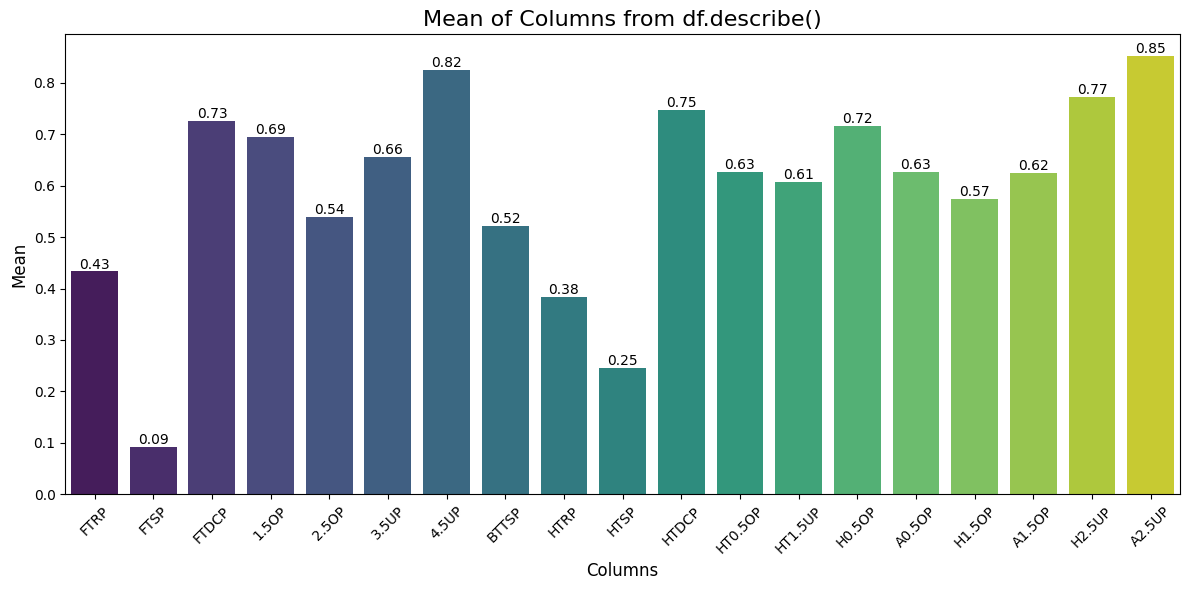

In [5]:
stats_df = combined_df[['League', 'Home', 'Away', 'FTRP', 'FTSP', 'FTDCP', '1.5OP',	'2.5OP', '3.5UP', '4.5UP', 'BTTSP',	
                        'HTRP',	'HTSP',	'HTDCP', 'HT0.5OP',	'HT1.5UP', 'H0.5OP', 'A0.5OP', 'H1.5OP', 'A1.5OP', 'H2.5UP',
                        'A2.5UP']]

import matplotlib.pyplot as plt
import seaborn as sns

print('Number of games: ', len(combined_df))
# Get the summary statistics
desc = stats_df.describe()

# Extract the 'mean' row
means = desc.loc['mean']

# Plotting the means using seaborn or matplotlib
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=means.index, y=means.values, palette="viridis")

# Add titles and labels
plt.title('Mean of Columns from df.describe()', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Mean', fontsize=12)

# Rotate the x labels if necessary for better readability
plt.xticks(rotation=45)

# Add text labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center',
                xytext=(0, 5),  # offset label from bar
                textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()

# Checking Threshold Values

In [6]:
import numpy as np

# Calculate the optimal threshold and best accuracy
def calculate_threshold(percentages, correctness):
    # Normalize the percentages to be between 0 and 1
    percentages = [p / 100 for p in percentages]

    best_threshold = 0
    best_accuracy = 0
    for threshold in np.unique(percentages):
        predicted_correctness = [1 if p >= threshold else 0 for p in percentages]
        accuracy = np.mean(np.array(predicted_correctness) == np.array(correctness))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    return round(best_threshold * 100, 2), round(best_accuracy * 100, 2)

print('Number of games: ', len(combined_df))
dc1x = combined_df[combined_df['DC1X'] >= combined_df[['DC12', 'DCX2']].max(axis=1)]
dc12 = combined_df[combined_df['DC12'] >= combined_df[['DC1X', 'DCX2']].max(axis=1)]
dcx2 = combined_df[combined_df['DCX2'] >= combined_df[['DC1X', 'DC12']].max(axis=1)]

htdc1x = combined_df[combined_df['HTDC1X'] >= combined_df[['HTDC12', 'HTDCX2']].max(axis=1)]
htdc12 = combined_df[combined_df['HTDC12'] >= combined_df[['HTDC1X', 'HTDCX2']].max(axis=1)]
htdcx2 = combined_df[combined_df['HTDCX2'] >= combined_df[['HTDC1X', 'HTDC12']].max(axis=1)]

dc1x_t, dc1x_a = calculate_threshold(dc1x['DC1X'], dc1x['FTDCP'])
dc12_t, dc12_a = calculate_threshold(dc12['DC12'], dc12['FTDCP'])
dcx2_t, dcx2_a = calculate_threshold(dcx2['DCX2'], dcx2['FTDCP'])

htdc1x_t, htdc1x_a = calculate_threshold(htdc1x['HTDC1X'], htdc1x['HTDCP'])
htdc12_t, htdc12_a = calculate_threshold(htdc12['HTDC12'], htdc12['HTDCP'])
htdcx2_t, htdcx2_a = calculate_threshold(htdcx2['HTDCX2'], htdcx2['HTDCP'])

print(f'DC1X threshold value: {dc1x_t}, accuracy: {dc1x_a}, games {len(dc1x)}      HTDC1X threshold value: {htdc1x_t}, accuracy: {htdc1x_a}, games {len(htdc1x)}')
print(f'DC12 threshold value: {dc12_t}, accuracy: {dc12_a}, games {len(dc12)}      HTDC12 threshold value: {htdc12_t}, accuracy: {htdc12_a}, games {len(htdc12)}')
print(f'DCX2 threshold value: {dcx2_t}, accuracy: {dcx2_a}, games {len(dcx2)}      HTDCX2 threshold value: {htdcx2_t}, accuracy: {htdcx2_a}, games {len(htdcx2)}')
print(" ")

ft1 = combined_df[combined_df['FT1'] >= combined_df[['FTX', 'FT2']].max(axis=1)]
ftx = combined_df[combined_df['FTX'] >= combined_df[['FT1', 'FT2']].max(axis=1)]
ftx = ftx[ftx['FTX'] < 100]
ft2 = combined_df[combined_df['FT2'] >= combined_df[['FT1', 'FTX']].max(axis=1)]

ht1 = combined_df[combined_df['HT1'] >= combined_df[['HTX', 'HT2']].max(axis=1)]
htx = combined_df[combined_df['HTX'] >= combined_df[['HT1', 'HT2']].max(axis=1)]
htx = htx[htx['HTX'] < 100]
ht2 = combined_df[combined_df['HT2'] >= combined_df[['HT1', 'HTX']].max(axis=1)]

ft1_t, ft1_a = calculate_threshold(ft1['FT1'], ft1['FTRP'])
ftx_t, ftx_a = calculate_threshold(ftx['FTX'], ftx['FTRP'])
ft2_t, ft2_a = calculate_threshold(ft2['FT2'], ft2['FTRP'])

ht1_t, ht1_a = calculate_threshold(ht1['HT1'], ht1['HTRP'])
htx_t, htx_a = calculate_threshold(htx['HTX'], htx['HTRP'])
ht2_t, ht2_a = calculate_threshold(ht2['HT2'], ht2['HTRP'])

print(f'FT1 threshold value: {ft1_t}, accuracy: {ft1_a}, games {len(ft1)}       HT1 threshold value: {ht1_t}, accuracy: {ht1_a}, games {len(ht1)}')
print(f'FTX threshold value: {ftx_t}, accuracy: {ftx_a}, games {len(ftx)}       HTX threshold value: {htx_t}, accuracy: {htx_a}, games {len(htx)}')
print(f'FT2 threshold value: {ft2_t}, accuracy: {ft2_a}, games {len(ft2)}       HT2 threshold value: {ht2_t}, accuracy: {ht2_a}, games {len(ht2)}')
print(" ")

over_15 = combined_df[combined_df['1.5O'] > 50]
under_15 = combined_df[combined_df['1.5O'] <= 50]

htover_05 = combined_df[combined_df['HT0.5O'] > 50]
htunder_05 = combined_df[combined_df['HT0.5O'] <= 50]

o15_t, o15_a = calculate_threshold(over_15['1.5O'], over_15['1.5OP'])
u15_t, u15_a = calculate_threshold(under_15['1.5O'], under_15['1.5OP'])
ht05o_t, ht05o_a = calculate_threshold(htover_05['HT0.5O'], htover_05['HT0.5OP'])
ht05u_t, ht05u_a = calculate_threshold(htunder_05['HT0.5O'], htunder_05['HT0.5OP'])

print(f'1.5Over threshold value: {o15_t}, accuracy: {o15_a}, games {len(over_15)}       HTOver0.5 threshold value: {ht05o_t}, accuracy: {ht05o_a}, games {len(htover_05)}')
print(f'1.5Under threshold value: {u15_t}, accuracy: {u15_a}, games {len(under_15)}     HTUnder0.5 threshold value: {ht05u_t}, accuracy: {ht05u_a}, games {len(htunder_05)}')
print(" ")

over_25 = combined_df[combined_df['2.5O'] > 50]
under_25 = combined_df[combined_df['2.5O'] <= 50]

htover_15 = combined_df[combined_df['HT1.5U'] <= 50]
htunder_15 = combined_df[combined_df['HT1.5U'] > 50]

o25_t, o25_a = calculate_threshold(over_25['2.5O'], over_25['2.5OP'])
u25_t, u25_a = calculate_threshold(under_25['2.5O'], under_25['2.5OP'])
ht15o_t, ht15o_a = calculate_threshold(htover_15['HT1.5U'], htover_15['HT1.5UP'])
ht15u_t, ht15u_a = calculate_threshold(htunder_15['HT1.5U'], htunder_15['HT1.5UP'])

print(f'2.5Over threshold value: {o25_t}, accuracy: {o25_a}, games {len(over_25)}       HTOver1.5 threshold value: {ht15o_t}, accuracy: {ht15o_a}, games {len(htover_15)}')
print(f'2.5Under threshold value: {u25_t}, accuracy: {u25_a}, games {len(under_25)}     HTUnder1.5 threshold value: {ht15u_t}, accuracy: {ht15u_a}, games {len(htunder_15)}')
print(" ")

over_35 = combined_df[combined_df['3.5U'] <= 50]
under_35 = combined_df[combined_df['3.5U'] > 50]

home_over_05 = combined_df[combined_df['H0.5O'] > 50]
home_under_05 = combined_df[combined_df['H0.5O'] <= 50]

o35_t, o35_a = calculate_threshold(over_35['3.5U'], over_35['3.5UP'])
u35_t, u35_a = calculate_threshold(under_35['3.5U'], under_35['3.5UP'])

hover_t, hover_a = calculate_threshold(home_over_05['H0.5O'], home_over_05['H0.5OP'])
hunder_t, hunder_a = calculate_threshold(home_under_05['H0.5O'], home_under_05['H0.5OP'])

print(f'3.5Over threshold value: {o35_t}, accuracy: {o35_a} games {len(over_35)}        HomeOver0.5 threshold: {hover_t}, accuracy: {hover_a}, games {len(home_over_05)}')
print(f'3.5Under threshold value: {u35_t}, accuracy: {u35_a} games {len(under_35)}      HomeUnder0.5 threshold: {hunder_t}, accuracy: {hunder_a}, games {len(home_under_05)}')
print(" ")

over_45 = combined_df[combined_df['4.5U'] <= 50]
under_45 = combined_df[combined_df['4.5U'] > 50]

away_over_05 = combined_df[combined_df['A0.5O'] > 50]
away_under_05 = combined_df[combined_df['A0.5O'] <= 50]

o45_t, o45_a = calculate_threshold(over_45['4.5U'], over_45['4.5UP'])
u45_t, u45_a = calculate_threshold(under_45['4.5U'], under_45['4.5UP'])
aover_t, aover_a = calculate_threshold(away_over_05['A0.5O'], away_over_05['A0.5OP'])
aunder_t, aunder_a = calculate_threshold(away_under_05['A0.5O'], away_under_05['A0.5OP'])

print(f'4.5Over threshold value: {o45_t}, accuracy: {o45_a}, games {len(over_45)}       AwayOver0.5 threshold: {aover_t}, accuracy: {aover_a}, games {len(away_over_05)}')
print(f'4.5Under threshold value: {u45_t}, accuracy: {u45_a}, games {len(under_45)}     AwayUnder0.5 threshold: {aunder_t}, accuracy: {aunder_a}, games {len(away_under_05)}')
print(" ")

btts = combined_df[combined_df['BTTS'] > 50]
otts = combined_df[combined_df['BTTS'] <= 50]

home_over_15 = combined_df[combined_df['H1.5O'] > 50]
home_under_15 = combined_df[combined_df['H1.5O'] <= 50]
away_over_15 = combined_df[combined_df['A1.5O'] > 50]
away_under_15 = combined_df[combined_df['A1.5O'] <= 50]

btts_t, btts_a = calculate_threshold(btts['BTTS'], btts['BTTSP'])
otts_t, otts_a = calculate_threshold(otts['BTTS'], otts['BTTSP'])
hover15_t, hover15_a = calculate_threshold(home_over_15['H1.5O'], home_over_15['H1.5OP'])
hunder15_t, hunder15_a = calculate_threshold(home_under_15['H1.5O'], home_under_15['H1.5OP'])
aover15_t, aover15_a = calculate_threshold(away_over_15['A1.5O'], away_over_15['A1.5OP'])
aunder15_t, aunder15_a = calculate_threshold(away_under_15['A1.5O'], away_under_15['A1.5OP'])

print(f'BTTS threshold value: {btts_t}, accuracy: {btts_a}, games: {len(btts)},     HomeOver1.5 T: {hover15_t}, A: {hover15_a}, G: {len(home_over_15)} HomeUnder1.5 T: {hunder15_t}, A: {hunder15_a}, G:{len(home_under_15)}')
print(f'OTTS threshold value: {otts_t}, accuracy: {otts_a}, games: {len(otts)}      AwayOver1.5 T: {aover15_t}, A: {aover15_a}, G: {len(away_over_15)} AwayUnder1.5 T: {aunder15_t}, A: {aunder15_a}, G:{len(away_under_15)}')
print(" ")

Number of games:  1076
DC1X threshold value: 66.7, accuracy: 78.88, games 483      HTDC1X threshold value: 9.04, accuracy: 78.83, games 614
DC12 threshold value: 67.34, accuracy: 71.71, games 304      HTDC12 threshold value: 76.2, accuracy: 66.15, games 65
DCX2 threshold value: 49.08, accuracy: 62.98, games 289      HTDCX2 threshold value: 0.08, accuracy: 71.5, games 400
 
FT1 threshold value: 53.53, accuracy: 58.66, games 583       HT1 threshold value: 80.05, accuracy: 58.91, games 331
FTX threshold value: 88.16, accuracy: 66.67, games 135       HTX threshold value: 80.31, accuracy: 58.52, games 540
FT2 threshold value: 84.34, accuracy: 65.45, games 356       HT2 threshold value: 81.62, accuracy: 75.94, games 187
 
1.5Over threshold value: 51.18, accuracy: 75.34, games 945       HTOver0.5 threshold value: 50.1, accuracy: 71.82, games 834
1.5Under threshold value: 49.76, accuracy: 70.23, games 131     HTUnder0.5 threshold value: 50.0, accuracy: 68.18, games 242
 
2.5Over threshold valu

# Checking League Stats

In [7]:
df_dropped = stats_df.drop(columns=['Home', 'Away'])

# Ensure 'League' is treated as categorical if needed
df_dropped['League'] = df_dropped['League'].astype('category')

# Group by 'League' and calculate mean for numeric columns
grouped_means = df_dropped.groupby('League').mean()

# Reset index to include 'League' as a column in the result
grouped_means = grouped_means.reset_index()

#Calculate average row-vise
numeric_cols = grouped_means.select_dtypes(include='number')
grouped_means['Average'] = numeric_cols.mean(axis=1)
league_counts = df_dropped.groupby('League').size().reset_index(name='Matches')
grouped_df = grouped_means.merge(league_counts, on='League', how='left')

# Reorder the columns: 'League', then 'count', followed by the mean columns
columns = ['League', 'Average', 'Matches'] + [col for col in grouped_df.columns if col not in ['League', 'Average', 'Matches']]

# Reassign the DataFrame with reordered columns
grouped_df = grouped_df[columns]
grouped_df = grouped_df[grouped_df['Matches'] > 9]
grouped_df.sort_values(by = 'Average', ascending = False)


,League,Average,Matches,FTRP,FTSP,FTDCP,1.5OP,2.5OP,3.5UP,4.5UP,BTTSP,HTRP,HTSP,HTDCP,HT0.5OP,HT1.5UP,H0.5OP,A0.5OP,H1.5OP,A1.5OP,H2.5UP,A2.5UP
4,Brazil,0.646424,39,0.410256,0.179487,0.743590,0.666667,0.487179,0.743590,0.923077,0.538462,0.589744,0.358974,0.897436,0.692308,0.666667,0.743590,0.538462,0.589744,0.769231,0.769231,0.974359
35,Sweden,0.645933,33,0.454545,0.090909,0.727273,0.757576,0.515152,0.878788,0.969697,0.424242,0.393939,0.393939,0.848485,0.484848,0.727273,0.727273,0.575758,0.606061,0.818182,0.909091,0.969697
33,Spain,0.644444,45,0.488889,0.111111,0.800000,0.600000,0.577778,0.777778,0.822222,0.488889,0.600000,0.400000,0.755556,0.644444,0.777778,0.622222,0.577778,0.622222,0.800000,0.822222,0.955556
38,Usa,0.628614,71,0.478873,0.084507,0.816901,0.830986,0.591549,0.577465,0.788732,0.619718,0.464789,0.225352,0.788732,0.732394,0.676056,0.830986,0.760563,0.563380,0.563380,0.732394,0.816901
10,England3,0.620243,65,0.507692,0.138462,0.707692,0.738462,0.646154,0.661538,0.753846,0.615385,0.400000,0.261538,0.738462,0.661538,0.661538,0.676923,0.707692,0.630769,0.615385,0.769231,0.892308
0,Argentina,0.620137,46,0.456522,0.108696,0.673913,0.500000,0.608696,0.869565,0.956522,0.478261,0.500000,0.326087,0.782609,0.652174,0.673913,0.608696,0.391304,0.543478,0.847826,0.869565,0.934783
29,Portugal,0.615385,26,0.461538,0.038462,0.884615,0.538462,0.423077,0.653846,0.884615,0.576923,0.500000,0.307692,0.923077,0.653846,0.692308,0.653846,0.576923,0.653846,0.692308,0.769231,0.807692
7,Denmark,0.612188,19,0.315789,0.105263,0.842105,0.947368,0.631579,0.578947,0.789474,0.631579,0.210526,0.157895,0.894737,0.736842,0.578947,0.894737,0.684211,0.578947,0.526316,0.789474,0.736842
3,Belgium,0.609800,29,0.310345,0.172414,0.689655,0.793103,0.620690,0.724138,0.827586,0.482759,0.551724,0.275862,0.758621,0.655172,0.344828,0.758621,0.655172,0.586207,0.689655,0.758621,0.931034
23,Mexico,0.603129,37,0.432432,0.162162,0.702703,0.540541,0.567568,0.729730,0.837838,0.567568,0.378378,0.297297,0.702703,0.702703,0.648649,0.675676,0.513514,0.648649,0.675676,0.810811,0.864865
